# Analisis dinamico modal espectral
Modelado con uso de `API de CSi` y `Python`

In [ ]:
# !pip install numpy matplotlib pandas comtypes

In [ ]:
import os, sys, ctypes
import numpy as np
import pandas as pd

import comtypes.client
from matplotlib import pyplot as plt

### 1. Uso de sistema de Unidades

In [2]:
# Unidades Base mks
m = 1
kg = 1
s = 1

# Otras Unidades
cm = 0.01*m
kgf = 9.80665*kg*m/s**2
tonf = 1000*kgf

# Constantes Físicas
g = 9.80665*m/s**2

### 2. Propiedades, materiales y geometria o modelo

#### Deinficion de los materiales

In [3]:
fc = 280*kg/cm**2           # Resistencia a la compresion
E = 150*fc**0.5*kgf/cm**2   # Modulo de elasticidad
v = 0.2
G = 0.5*E/(1+v)           # Modulo de corte
coeficienteTermico = 0.0000055 #T

material_type = 2;
material_name = f'fc={str(fc)} kg/cm^2'; # fc=280kg/cm^2

#### Defincion de seccion

In [4]:
# secciones para la viga y columna
secBeamb = 30*cm # cm
secBeamh = 60*cm # cm
beamName = f'V{str(secBeamb)}x{str(secBeamh)}'
secColumnb = 45*cm # cm
secColumnh = 45*cm # cm
columnName = f'C{str(secColumnb)}x{str(secColumnh)}'

# Densidad del concreto
ρ = 2400*kg/m**3

#### Coordenadas, Elementos, restricciones, apoyos

In [5]:
# vertices o coordenadas
#   coords[x,y,z]
coords = pd.read_excel('data.xlsx', sheet_name='nodos')
coords = coords.to_numpy(dtype = np.float64)
# miembros o elementos
#   elems[node_i, node_j, columna o viga]
elems =  pd.read_excel('data.xlsx', sheet_name='elementos')
elems = elems.to_numpy(dtype = np.float64)
# Restricciones o condiciones de 
#   apoyos[idNode, Fx, Fy, Fz, Rx, Ry, Rz]
apoyos = np.array([
    [0, True, True, True, True, True, True],
    [1, True, True, True, True, True, True],
    [2, True, True, True, True, True, True],
    [3, True, True, True, True, True, True],
    [4, True, True, True, True, True, True],
    [5, True, True, True, True, True, True],
    [6, True, True, True, True, True, True],
    [7, True, True, True, True, True, True],
    [8, True, True, True, True, True, True],
    [9, True, True, True, True, True, True]
]);
# cargas puntual
#   cargaPuntual[idNodo, Fx, Fy, Fz, Rx, Ry, Rz]
cargaPuntual = np.array([
    [4, 0,0,-10,0,0,0],
    [6, 0,0,-10,0,0,0]
])
# carga distribuidas
#   cargasDistr[idElem, node_i, node_j, F/L, [1:g,2:r,3:b], i, j, tipoCarga, node_i, node_j, F/L, [1:g,2:r,3:b], i, j, tipoCarga]
cargasDistr = np.array([
    [4, -0.4, -0.4, 1, 2, 0, 1, "Dead", -0.4, -0.4, 1, 2, 0, 1, "Live"],
    [5, -0.4, -0.4, 1, 2, 0, 1, "Dead", -0.25, -0.25, 1, 2, 0, 1, "Live"]
])

# Indicar el programa a usar
connect_to = 2; #1 para SAP2000 y 2 para ETABS
# Variable para definir una instancia manual para el programa y definir la ruta.
rutaEspecifica = False

nn = np.shape(coords)[0]
ne = np.shape(elems)[0]

nameModelProject = 'Edificio de 4 Niveles'

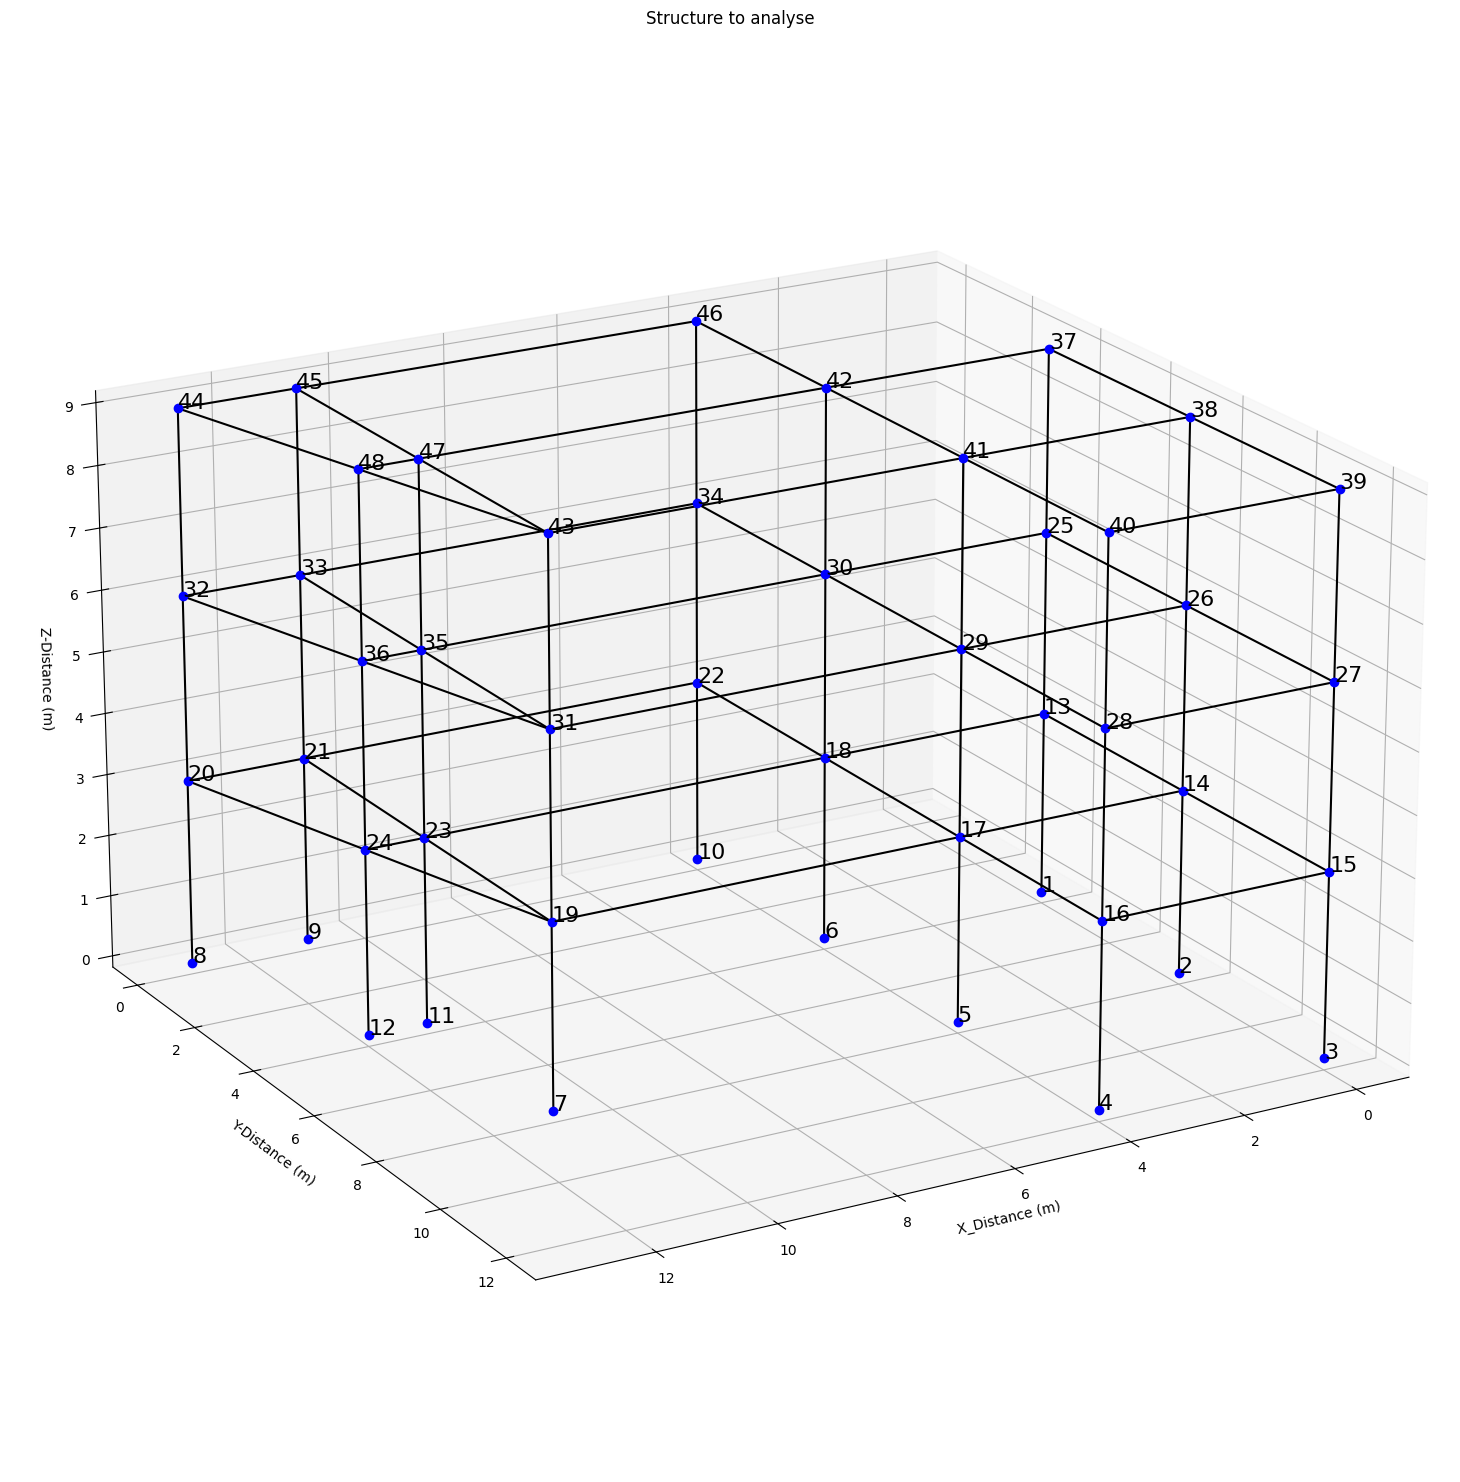

In [ ]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1, 3,3], projection='3d') # Indicate a 3D plot
axes.view_init(20, 60) # Set the viewing angle of the 3D plot

#Plot members
for mbr in elems:
    node_i = int(mbr[0]) #Node number for node i of this member
    node_j = int(mbr[1]) #Node number for node j of this member

    ix = coords[node_i-1,0] #x-coord of node i of this member
    iy = coords[node_i-1,1] #y-coord of node i of this member
    iz = coords[node_i-1,2] #z-coord of node i of this member
    jx = coords[node_j-1,0] #x-coord of node j of this member
    jy = coords[node_j-1,1] #y-coord of node j of this member
    jz = coords[node_j-1,2] #z-coord of node j of this member

    # Calculate direction cosines
    dx = jx-ix #x-component of vector along member
    dy = jy-iy #y-component of vector along member
    dz = jz-iz #z-component of vector along member
    mag = np.sqrt(dx**2 + dy**2 + dz**2) # Magnitude of vector (length of member)

    axes.plot3D([ix,jx],[iy,jy],[iz,jz],'k') # Plot 3D node

#Plot coords
for n, node in enumerate(coords):
    axes.plot3D([node[0]],[node[1]], [node[2]],'ob', ms=6) # Plot 3D node
    label = str(n+1) # Node number label
    axes.text(node[0], node[1], node[2], label, fontsize=16) # Add node label

# Make the aspect ratio equal
fig.gca().set_aspect('equal', adjustable='box') # comentar en caso de usar margenes ajustados

axes.set_xlabel('X_Distance (m)')
axes.set_ylabel('Y-Distance (m)')
axes.set_zlabel('Z-Distance (m)')
axes.set_title(f'{nameModelProject}')
axes.grid()

### 3. Coneccion

In [697]:
smodel, ret = None, None
conn = {};
if connect_to == 1:  # SAP2000
    print("SAP2000")
    conn = {
        'app_ruta': "C:\\Program Files\\Computers and Structures\\SAP2000 23\\SAP2000.exe",
        'app_adjunto': "CSI.SAP2000.API.SapObject",
        'app_helper': 'SAP2000v1.Helper'
        }
elif (connect_to == 2): # ETABS
    print("ETABS")
    conn = {
        'app_ruta': "C:\\Program Files\\Computers and Structures\\ETABS 21\\ETABS.exe",
        'app_adjunto': "CSI.ETABS.API.ETABSObject",
        'app_helper': "ETABSv1.Helper"
        }
else: 
    print("No tenemos soporte aun")
    sys.exit()

ETABS


In [ ]:
try:
    connect_to_app = comtypes.client.GetActiveObject(conn['app_adjunto'])
    print("Coneccion exitosa!.\nadjuntando a una instancia existente.")
except (OSError, comtypes.COMError):
    print("No se encontró ninguna instancia en ejecución del programa(Etabs).")

    print("Tratando de Ejecutar!.")
    #create API helper object
    helper = comtypes.client.CreateObject(conn['app_helper'])
    if connect_to == 1:
        helper = helper.QueryInterface(comtypes.gen.SAP2000v1.cHelper)
    else:
        helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper);
    # helper = comtypes.client.CreateObject(conn['app_helper']).QueryInterface()
    if rutaEspecifica: # para versiones anteriores a la ultima version instalada
        ProgramPath = conn['app_ruta'];
        try:
            connect_to_app = helper.CreateObject(ProgramPath)
            print("Coneccion establecida!.\nConexion Manual")
        except (OSError, comtypes.COMError):
            print("Cannot start a new instance of the program from " + ProgramPath)
            sys.exit(-1)
    else:
        try: 
            connect_to_app = helper.CreateObjectProgID(conn['app_adjunto']) 
            print("Coneccion establecida!.")
        except (OSError, comtypes.COMError):
            print("Cannot start a new instance of the program.")
            sys.exit(-1)
    print("Ejecutando!.  ultima version instalada o existente")
    #start ETABS application | ejecutar la Aplicacion ETABS.
    connect_to_app.ApplicationStart()

smodel = connect_to_app.SapModel;

No se encontró ninguna instancia en ejecución del programa(Etabs).
Tratando de Ejecutar etabs!.
Coneccion establecida!.
Ejecutando!.  ultima version instalada o existente


### 4. Se crea un nuevo Lienzo y Modelo

In [699]:
# Unit Preferences | Preferencias de Sistema de Unidades
kN_m_C = 6
kgf_m_C = 8
Tonf_m_C = 12

In [700]:
smodel.SetPresentUnits(kN_m_C)
# get present units | Optener la presente unidad(s)
print(smodel.GetPresentUnits())

6


In [701]:
smodel.SetModelIsLocked(False)

# Se crea un nuevo lienzo
# smodel.InitializeNewModel; # esto es valido tambien
smodel.InitializeNewModel(Tonf_m_C)

# # create grid-only template model | Crea una nueva hoja con grilla
response_status = smodel.File.NewGridOnly(3, 3*m,3*m, 5*m,4*m, 4*m,4*m)

response_status

0

In [702]:
smodel.View.RefreshView(0, False);

### modificndo las grillas

**Crear una nueva grilla**

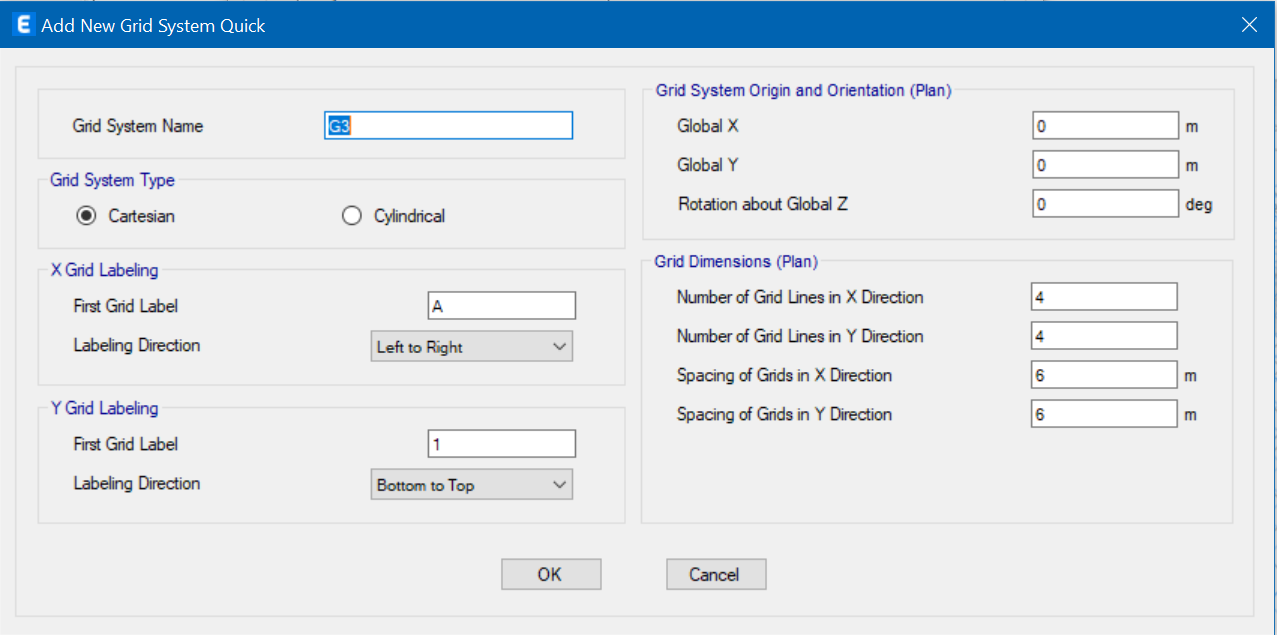

C#
```c#
int GetGeometricNonlinearity(
	string Name,
	ref int NLGeomType
)
```
python
```py
int GetGeometricNonlinearity(
	Name -> str,
	NLGeomType -> int
) -> int
```


In [716]:
# # 'define new grid system - SetGridSys['Grid system Name', 'Global X', 'Global Y', 'Rotation about Global Z']
# response_status = smodel.GridSys.SetGridSys("G2", 0,0,0)
# display(response_status)

# # 'get new grid system data
# response_status = smodel.GridSys.GetGridSys("G1", 0, 0, 0)
# display(response_status)

In [707]:
# Xo, Yo, RZ = .0, .0, .0
# NumXLines, NumYLines = 0,0
# GridLineIDX, GridLineIDY = [], []
# OrdinateX, OrdinateY = [],[]
# VisibleX, VisibleY = [], []
# BubbleLocX, BubbleLocY = [], []
# response_status = smodel.GridSys.GetGridSys_2(Name, Xo,Yo,RZ, '', NumXLines,NumYLines, GridLineIDX,GridLineIDY, OrdinateX,OrdinateY, VisibleX,VisibleY, BubbleLocX,BubbleLocY)
# display(response_status)

In [709]:
# # tipo de grilla Cartesian o Cylindrical
# Name, GridSysType = 'G2', ''
# nameGridSystem = smodel.GridSys.GetGridSysType(Name,GridSysType)[0]
# display(nameGridSystem)

In [ ]:
# NumberNames, MyName = 0, ''
# infoPisos = smodel.Story.GetNameList(NumberNames, MyName)
# numPisos = infoPisos[0]

# alturaPisos, PisoMaestro, pisoSimilares = [], [], []
# espcioAltura, = [],
# for i in range(numPisos):
#     nameStory = infoPisos[1][i]
#     # altura por piso
#     Height = .0
#     alturaPiso = smodel.Story.GetHeight(nameStory, Height)
#     alturaPisos.append(alturaPiso[0])
#     # display([nameStory, alturaPiso])
#     # altura en elevacion
#     Elevation = 0.0;
#     response_status = smodel.Story.GetElevation(nameStory, Elevation)
#     display(response_status)
#     # 'get story master story
#     MasterStory = True
#     pisoMaestro = smodel.Story.GetMasterStory(nameStory, MasterStory)
#     PisoMaestro.append(pisoMaestro[0])
#     # display(pisoMaestro)
#     # Similaridad por piso
#     MasterStory, SimilarToStory = pisoMaestro, ''
#     pisoSimilar = smodel.Story.GetSimilarTo(nameStory, MasterStory, SimilarToStory)
#     pisoSimilares.append(pisoSimilar[1])
#     # display(pisoSimilar)
#     # 'get story splice information
#     SpliceAbove, SpliceHeight = True, .0
#     espacioAlt = smodel.Story.GetSplice(nameStory, SpliceAbove, SpliceHeight)
#     espcioAltura.append(espacioAlt[0])
#     # display(espacioAlt)
# # 'set stories
# inStoryNames = set(infoPisos[1][:])
# inStoryHeights = alturaPisos # {}
# inIsMasterStory = PisoMaestro # {}
# inSimilarToStory = pisoSimilares # {}
# inSpliceAbove = espcioAltura # {}
# inSpliceHeight = {0, 1, 0}
# inColor = {65535, 255, 16711935}

# ret = smodel.Story.SetStories_2(2.0, 6, inStoryNames, inStoryHeights, inIsMasterStory, 
#                                 inSimilarToStory, inSpliceAbove, inSpliceHeight, inColor)

### 5. Se establece las propiedades del concreto

In [676]:
# definicion del material
response_status = smodel.PropMaterial.SetMaterial( material_name, material_type )
# propiedades mecanicas del material
response_status = smodel.PropMaterial.SetMPIsotropic( material_name, E, v, coeficienteTermico )
display(response_status)

0

In [677]:
# Secciones de viga y columna
response_status = smodel.PropFrame.SetRectangle(beamName, material_name, secBeamb, secBeamh) # seecion para la viga
response_status = smodel.PropFrame.SetRectangle(columnName, material_name, secColumnb, secColumnh) # seccion para la columna
display(response_status)

0

### 6. Geometria de la estructura

In [678]:
# 2da forma de ingreso
FrameName1 = ''
mbrName = '';
for idx, mbr in enumerate(elems):
    deNodo = int(mbr[0])-1
    alNodo = int(mbr[1])-1
    identificador = int(mbr[2]) # columna o viga
    xi, yi, zi = coords[deNodo, 0], coords[deNodo, 1], coords[deNodo, 2]
    xf, yf, zf = coords[alNodo, 0], coords[alNodo, 1], coords[alNodo, 2]
    if identificador == 1: # columnas
        mbrName = columnName
    elif identificador == 2: # vigas
        mbrName = beamName
    else: pass
    [FrameName1, response_status] = smodel.FrameObj.AddByCoord(
        xi,yi,zi, xf,yf,zf, "FrameName"+str(idx+1), mbrName, str(idx+1), 'Global'
        # xi,yi,zi, xf,yf,zf, str(idx+1), mbrName, str(idx+1), 'Global'
    )
    # display(response_status)

In [679]:
smodel.View.RefreshView(0, False);

**Agregando losas**

In [680]:
# registro de vertices en planta [i,j,k,l]
losas = [[0,5,4,1],     # 1
         [1,4,3,2],     # 2
         [5,10,6,4],    # 3
         [9,8,10,5],    # 4
         [8,7,11,10],   # 5
         [10,11,6,6]]   # 6
# areas = np.zeros(12,"f8")
numeroPuntosLosa = len(losas[0])

In [681]:
NumberNames, MyName = 0, ''
infoPisos = smodel.Story.GetNameList(NumberNames, MyName)
numPisos = infoPisos[0]

for piso in range(1, numPisos+1):
    print(f"Estoy en el Piso {piso}")
    nameStory = infoPisos[1][piso-1]
    # altura en elevacion
    Elevation = 0.0;
    alturaElevacionAcumulativa = smodel.Story.GetElevation(nameStory, Elevation)
    for i in range(len(losas)):
        xyz = coords[losas[i]]
        x = list(xyz[:,0])
        y = list(xyz[:,1])
        z = list(xyz[:,2] + alturaElevacionAcumulativa[0])
        nombreLosa = "f2" #f"P{str(piso)}Losa{str(i+1)}"
        tipoSeccion = "Slab1" #f"P{str(piso)}Slab{str(i+1)}"
        response_status = smodel.AreaObj.AddByCoord(numeroPuntosLosa, x, y, z, nombreLosa, tipoSeccion, "Global")
    # smodel.View.RefreshView(0, False);

Estoy en el Piso 1
Estoy en el Piso 2
Estoy en el Piso 3


In [682]:
smodel.View.RefreshView(0, False);

### 7. Restricciones o condiciones de borde (apoyos)

In [687]:
nrestrict = apoyos.shape[0]
node_i, node_j = ' ', ' '
for node, restricts in enumerate(apoyos):
    [node_i, node_j, response_status] = smodel.FrameObj.GetPoints(str(restricts[0]+1), node_i, node_j)
    response_status = smodel.Pointobj.SetRestraint(node_i, [*apoyos[node,1::]]);
    # print(response_status, ["FrameName"+str(restricts[0]+1),[*apoyos[node,1::]]])

In [688]:
smodel.View.RefreshView(0, False);

### 8. Se establece carga puntual y distribuida

In [689]:
# # Establecemos patron de carga
# LTYPE_OTHER = 8
# nombreF = "FuerzaH"
# response_status = smodel.LoadPatterns.Add(nombreF, LTYPE_OTHER, 1, True)
# response_status

In [690]:
# # # Cargas puntuales
# # ncp = cargas.shape[0]# numero de cargas puntuales 
# # for idx in range(ncp):
# #     [PointName1, PointName2, response_status] = smodel.FrameObj.GetPoints("FrameName"+str(idx), PointName1, PointName2)
# #     print(response_status)

# PointName1, PointName2 = ' ',' '
# PointLoadValue = [1, 0, 0, 0, 0, 0]
# [PointName1, PointName2, response_status] = smodel.FrameObj.GetPoints("FrameName"+str(idx), PointName1, PointName2)
# [PointName1, PointName2, response_status] = smodel.FrameObj.GetPoints("FrameName"+str(idx), PointName1, PointName2)
# response_status = smodel.PointObj.SetLoadForce(PointName1, "FuerzaH", PointLoadValue)
# response_status = smodel.PointObj.SetLoadForce(PointName2, "FuerzaH", PointLoadValue)
# response_status

In [691]:
# # # Cargas distribuidas (Dead and Live)
# # ncd = cargasDistr.shape[0]# numero de cargas puntuales 
# # lpName = "Test";
# # # 1 = Force per unit length
# # # 2 = Moment per unit length
# # for elem in range(ncd):
# #     nombre = "FrameName"+str(cargasDistr[elem,0])
# #     dead_i,dead_j  = cargasDistr[elem,1], cargasDistr[elem,2]
# #     dead_fl = cargasDistr[elem, 3]
# #     deadTransGeom = cargasDistr[elem, 4]
# #     di,dj = cargasDistr[elem, 5], cargasDistr[elem, 6]
# #     deadName = cargasDistr[elem,7]
# #     live_i, live_j = cargasDistr[elem,8], cargasDistr[elem,9]
# #     live_fl = cargasDistr[elem, 10]
# #     liveTransGeom = cargasDistr[elem, 11]
# #     li, lj = cargasDistr[elem, 12],cargasDistr[elem, 13]
# #     liveName = cargasDistr[elem,14]
    
# #     response_status = smodel.FrameObj.SetLoadDistributed(nombre, deadName, int(dead_fl), int(deadTransGeom), float(di), float(dj), float(dead_i), float(dead_j), "Local");
# #     response_status = smodel.FrameObj.SetLoadDistributed(nombre, liveName, int(live_fl), int(liveTransGeom), float(li), float(lj), float(live_i), float(live_j), "Local");
# FrameName4, FrameName5 = ' ',' '
# response_status = smodel.FrameObj.SetLoadDistributed(FrameName4, "Dead", 1, 2, 0,1, -0.4, -0.4, "Local");
# response_status = smodel.FrameObj.SetLoadDistributed(FrameName4, "Live", 1, 2, 0,1, -0.25, -0.25, "Local");

# response_status = smodel.FrameObj.SetLoadDistributed(FrameName5, "Dead", 1, 2, 0,1, -0.4, -0.4, "Local");
# response_status = smodel.FrameObj.SetLoadDistributed(FrameName5, "Live", 1, 2, 0,1, -0.25, -0.25, "Local");

# response_status

### 11. Centros de masa

### 12. Formas modales

### 13. Coordenadas espectrales

### 14. Factores de participacion modal

### 15. Peso por piso y Peso total del edificio

### 16. Fuerzas, desplazamientos, velocidad, aceleracion modales

### 17. Suma de valores absolutos (ABS)

### 18. SRSS

### 19. Combinacion CQC

### 20. E030